# Analyzing Results of Main Experiments

*Version History*

* **9.0** - Visualize distribution of weights


## Preparation


### Imports & Constants

In [1]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from pyfonts import load_font

from src.models.lenet import LeNet
from src.visualization.color import get_color
from src.visualization.saving import save_figure


# Custom font & color
INDIE_FLOWER = load_font(
   font_url="https://github.com/google/fonts/blob/main/ofl/indieflower/IndieFlower-Regular.ttf?raw=true"
)
ANTHRACITE = get_color("anthracite", tint=0.2)

# Paths
CHECKPOINT_DIR = "../out/lenet_fashionmnist/representational_similarity/methods/2024-10-20_11-09-04"
LENET_REF_CHECKPOINT = "../models/lenet_fashionmnist_basic/checkpoint.pt"

# CPU/GPU
DEVICE = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

# Reference LeNet-5
LENET_REF = LeNet().to(DEVICE)
LENET_REF.load_state_dict(
    torch.load(
        LENET_REF_CHECKPOINT,
        map_location=DEVICE,
        weights_only=False
    )["model_state_dict"]
)
LENET_REF.eval()

# Layer names
LAYER_ALIASES = {
    "net.0": "Conv-1",
    "net.3": "Conv-2",
    "net.6": "FC-1",
    "net.9": "FC-2",
    "net.11": "FC-3"
}

## Distribution of Weights

**1. Choose which methods to visualize weights for**

In [2]:
compute_list = ["correlation", "euclidean", "euclidean"]
compute_cntr_actv_list = ["None", "False", "False"]
compare_list = ["spearman", "spearman", "cosine"]
run_list = [1, 1, 1]

**2. Extract weights of LeNet-5s trained for dissimilarity**

In [3]:
# List to store all weights data.  This will later be converted into a DataFrame for plotting with seaborn.
weights_data: List[Tuple[str, str, str, float]] = []

for compute, compute_cntr_actv, compare, run in zip(compute_list, compute_cntr_actv_list, compare_list, run_list):
    # Load checkpoint
    checkpoint_path = (
        f"{CHECKPOINT_DIR}/"
        f"compute={compute},compare={compare},compute.cntr_actv={compute_cntr_actv}"
        f"/checkpoints/run{run}/best_performing.pt"
    )
    model_state_dict = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)["model_state_dict"]

    # Store weights in ``weights_data`` list
    compute_str = "pearson" if compute == "correlation" else compute
    compute_str = compute_str.capitalize() + (" (Centered)" if compute_cntr_actv == "True" else "")
    compare_str = "Cosine Similarity" if compare == "cosine" else compare
    for layer_name, weight_tensor in model_state_dict.items():
        if "weight" in layer_name:
            weights_flattened = weight_tensor.cpu().numpy().flatten()
            for weight in weights_flattened:
                weights_data.append((
                    "trained",
                    f"{compute_str} & {compare_str.title()}",
                    LAYER_ALIASES[layer_name.replace(".weight", "")],
                    weight
                ))

**3. Load weights of reference LeNet-5**

In [4]:
# Load checkpoint of reference LeNet-5
ref_state_dict = torch.load(
    LENET_REF_CHECKPOINT, map_location=DEVICE, weights_only=False
)["model_state_dict"]

# Store weights in ``weights_data`` list
for layer_name, weight_tensor in ref_state_dict.items():
    if "weight" in layer_name:
        weights_flattened = weight_tensor.cpu().numpy().flatten()
        for compute, compute_cntr_actv, compare in zip(compute_list, compute_cntr_actv_list, compare_list):
            compute_str = "pearson" if compute == "correlation" else compute
            compute_str = compute_str.capitalize() + (" (Centered)" if compute_cntr_actv == "True" else "")
            compare_str = "Cosine Similarity" if compare == "cosine" else compare
            for weight in weights_flattened:
                method = f"{compute}"
                weights_data.append((
                    "reference",
                    f"{compute_str} & {compare_str.title()}",
                    LAYER_ALIASES[layer_name.replace(".weight", "")],
                    weight
                ))

**4. Convert data to DataFrame**

In [5]:
weights_df = pd.DataFrame(weights_data, columns=["network", "method", "layer", "weight"])
weights_df.head(10)

,network,method,layer,weight
0,trained,Pearson & Spearman,Conv-1,0.140628
1,trained,Pearson & Spearman,Conv-1,-0.003578
2,trained,Pearson & Spearman,Conv-1,0.004035
3,trained,Pearson & Spearman,Conv-1,0.082725
4,trained,Pearson & Spearman,Conv-1,-0.186049
5,trained,Pearson & Spearman,Conv-1,0.173961
6,trained,Pearson & Spearman,Conv-1,-0.026177
7,trained,Pearson & Spearman,Conv-1,-0.013988
8,trained,Pearson & Spearman,Conv-1,0.076509
9,trained,Pearson & Spearman,Conv-1,-0.218709


**5. Visualize distributions**

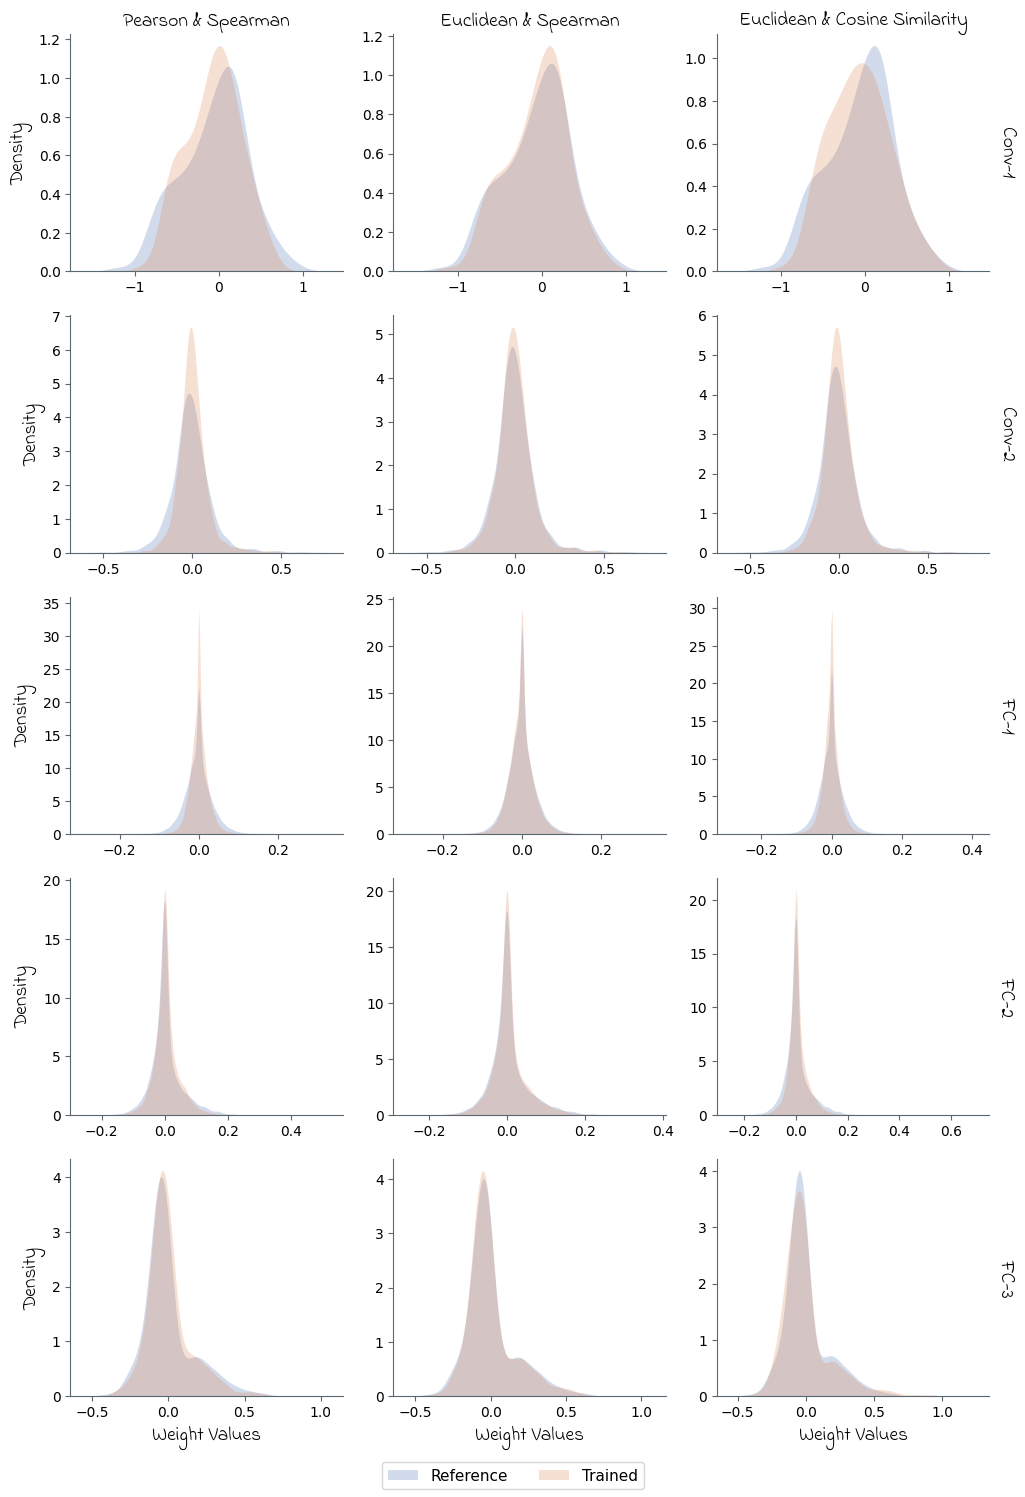

In [6]:
font_size = 14

with sns.axes_style({"axes.edgecolor": ANTHRACITE}):
    g = sns.FacetGrid(
        data=weights_df,
        row="layer",
        col="method",
        hue="network",
        sharex=False,
        sharey=False,
        aspect=1.15,
        palette="deep",
        hue_order=["reference", "trained"],
        margin_titles=True
    )
    _ = g.map(sns.kdeplot, "weight", fill=True, linewidth=0)

# Modify ticks, axis labels, & margin titles
g.tick_params(color=ANTHRACITE, labelsize=font_size - 4)
g.set_axis_labels("Weight Values", "Density", font=INDIE_FLOWER, size=font_size)
g.set_titles(
    row_template="{row_name}",
    col_template="{col_name}",
    font=INDIE_FLOWER,
    size=font_size
)

# Add legend
g.fig.legend(
    handles=g._legend_data.values(),
    labels=["Reference", "Trained"],
    loc="lower center",
    ncol=len(compute_list),
    fontsize=font_size - 3
)

plt.tight_layout(rect=(0, 0.02, 1, 1))  # adjusted for legend
plt.show()

In [7]:
# Save figure
fig_weights_dist = g.figure
save_figure(
    fig_weights_dist,
    "../reports/figures/lenet_fashionmnist/representational_similarity/analysis/weights_distribution.png"
)

Figure saved successfully as ../reports/figures/lenet_fashionmnist/representational_similarity/analysis/weights_distribution.png.
